In [1]:
import os
import datetime
import numpy as np
from miic.core.miic_utils import mat_to_ndarray
import miic.core.plot_fun as pf
import miic.core.miic_utils as mu
import miic.core.change_processing as chp
import matplotlib.pyplot as plt
from obspy.geodetics.base import gps2dist_azimuth
from copy import deepcopy
import matplotlib as mpl

ModuleNotFoundError: No module named 'miic'

In [2]:
data_path = '/home/pm/Documents/PhD/programes/miic/Scripts_nb'
figure_path = '/home/pm/Documents/PhD/programes/miic/Scripts_nb/figs'

stations = ['X9.OR13','X9.OR14']
channels = ['SHE','SHN','SHZ','HHN','HHE','HHZ']
fformat = "vchange_full_%s.%s.%s_%s.mat"

In [3]:
def stations_in_circle(coordinate_file, center_lat, center_lon, radius):
    ll_df = mu.lat_lon_ele_load(coordinate_file)
    stations = []
    for key in ll_df.index:
        dist,_,_ = gps2dist_azimuth(center_lat, center_lon, ll_df.latitude[key], ll_df.longitude[key])
        if dist < radius:
            stations.append('.'.join(key.split('.')[:2]))
    return stations
    
def plot_dv_list(dvl, n_average, filename):
    plt.figure(figsize=(7,4))
    tim = mu.convert_time(dvl[0]['time'])
    for dv in dvl:
        adv = chp.change_average(dv,n_average)
        plt.plot(tim,adv['value'],'k.',alpha=0.1)
    cdv = chp.dv_combine(dvl)
    acdv = chp.change_average(cdv,n_average)
    #plt.plot(tim,acdv['value'],'k')
    color_line(tim,acdv['value'],acdv['corr'])
    plt.title('%s' %(dvl[0]['stats']['station']))
    plt.xlim(datetime.datetime(2015,7,1),datetime.datetime(2016,8,1))
    plt.xticks([datetime.datetime(2015,7,1),datetime.datetime(2015,10,1),
                datetime.datetime(2016,1,1),datetime.datetime(2016,4,1),datetime.datetime(2016,7,1)],
              ['2015-07','2015-10','2016-01','2016-04','2016-07'])
    plt.ylim(-0.02,0.02)
    plt.ylabel('dv/v')
    plt.savefig(filename)
    return acdv


def color_line(x, y, c, cmap=mpl.cm.jet, norm=None, line=None, linewidth=6, marker='.', markersize=12, plot_colorbar=True):
    assert len(x)==len(y)
    assert len(c)==len(x)
    #assert len(norm) == 2, 'norm must be a two element tuple with min and max of colorrange'
    if type(norm)==type(None):
        norm = [min(c), max(c)]
    norm = mpl.colors.Normalize(vmin=norm[0], vmax=norm[1])

    if type(line) != type(None):
        xv = np.vstack([x[1:-1] - np.diff(x)[:-1]/2, x[1:-1], x[1:-1] + np.diff(x)[1:]/2])
        yv = np.vstack([y[1:-1] - np.diff(y)[:-1]/2, y[1:-1], y[1:-1] + np.diff(y)[1:]/2])
        mpl.pyplot.plot([x[0],x[0]+(x[0]-x[1])/2],[y[0],y[0]+(y[0]-y[1])/2],color=cmap(norm(c[0])),
                        linestyle=line,lw=linewidth,alpha=1)
        for ind in range(xv.shape[1]):
            mpl.pyplot.plot(xv[:,ind],yv[:,ind],color=cmap(norm(c[ind+1])),
                            linestyle=line,lw=linewidth,alpha=1)
        mpl.pyplot.plot([x[-2]+(x[-2]-x[-1])/2,x[-1]],[y[-2]+(y[-2]-y[-1])/2,y[-1]],color=cmap(norm(c[-1])),
                        linestyle=line,lw=linewidth,alpha=1)
    if type(marker) != type(None):
        for px,py,pc in zip(x,y,c):
            mpl.pyplot.plot(px,py,color=cmap(norm(pc)),alpha=1, marker=marker,markersize=markersize)
            
    if plot_colorbar:
        sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        ax = mpl.pyplot.colorbar(sm)
        ax.set_label('correlation')

In [4]:
coordinate_file = 'all_coordinates_chnls.txt'
center_lat = 55.75
center_lon = 161.05
radius = 10000
stations = stations_in_circle(coordinate_file,center_lat, center_lon,radius)
stations = list(set(stations))
len(stations)

97

In [28]:
station_pairs = []
for station1 in stations:
    net1,stat1 = station1.split('.')
    for station2 in stations:
        net2,stat2 = station2.split('.')
        if stat1 != stat2:
            station_pairs.append("%s%s.%s%s" % (net1,net2,stat1,stat2))

channel_pairs = []
for cha1 in channels:
    for cha2 in channels:
        channel_pairs.append("%s%s" % (cha1,cha2))

rdvl = []
for station_pair in station_pairs:
    pflist = []
    for channel_pair in channel_pairs:
        for location in ['','10','00']:
            tfile = os.path.join(data_path,station_pair,fformat % (station_pair,location,channel_pair,'left'))
            print(tfile)
            if os.path.exists(tfile):
                pflist.append(tfile)
            tfile = os.path.join(data_path,station_pair,fformat % (station_pair,location,channel_pair,'right'))
            if os.path.exists(tfile):
                pflist.append(tfile)
    if len(pflist) == 0:
        continue
    print station_pair
    dvl = []
    for pfile in pflist:
        dvl.append(mat_to_ndarray(pfile))
        
    fig_file = os.path.join(figure_path,station_pair+'.png')
    cdv = plot_dv_list(dvl,11,fig_file)
    rdvl.append(cdv)

if len(rdvl)>1:
    crcdv = chp.dv_combine_multi_ref(rdvl,method='diff')
    plt.figure(figsize=(7,4))
    tim = mu.convert_time(crcdvl['time'])
    color_line(tim,crcdvl['value'],crcdvl['corr'])
    plt.title('Joint dv/v')
    plt.savefig(os.path.join(figure_path,'Joint_dv.png'))

/home/pm/Documents/PhD/programes/miic/Scripts_nb/X9X9.SV9B08/vchange_full_X9X9.SV9B08..SHESHE_left.mat
/home/pm/Documents/PhD/programes/miic/Scripts_nb/X9X9.SV9B08/vchange_full_X9X9.SV9B08.10.SHESHE_left.mat
/home/pm/Documents/PhD/programes/miic/Scripts_nb/X9X9.SV9B08/vchange_full_X9X9.SV9B08.00.SHESHE_left.mat
/home/pm/Documents/PhD/programes/miic/Scripts_nb/X9X9.SV9B08/vchange_full_X9X9.SV9B08..SHESHN_left.mat
/home/pm/Documents/PhD/programes/miic/Scripts_nb/X9X9.SV9B08/vchange_full_X9X9.SV9B08.10.SHESHN_left.mat
/home/pm/Documents/PhD/programes/miic/Scripts_nb/X9X9.SV9B08/vchange_full_X9X9.SV9B08.00.SHESHN_left.mat
/home/pm/Documents/PhD/programes/miic/Scripts_nb/X9X9.SV9B08/vchange_full_X9X9.SV9B08..SHESHZ_left.mat
/home/pm/Documents/PhD/programes/miic/Scripts_nb/X9X9.SV9B08/vchange_full_X9X9.SV9B08.10.SHESHZ_left.mat
/home/pm/Documents/PhD/programes/miic/Scripts_nb/X9X9.SV9B08/vchange_full_X9X9.SV9B08.00.SHESHZ_left.mat
/home/pm/Documents/PhD/programes/miic/Scripts_nb/X9X9.SV9B08/

In [29]:
print(station_pairs)

['X9X9.SV9B08', 'X9YY.SV9BZW', 'X9YY.SV9BZM', 'X9X9.B08SV9', 'X9YY.B08BZW', 'X9YY.B08BZM', 'YYX9.BZWSV9', 'YYX9.BZWB08', 'YYYY.BZWBZM', 'YYX9.BZMSV9', 'YYX9.BZMB08', 'YYYY.BZMBZW']


In [6]:
chp.change_interpolate?

Signature: chp.change_interpolate(dv, search_range=None, fit_range=7)
Docstring:
Interpolate the similarity matrix to artificially decrease the
stretching increment

fit_range: number of stretch values on each side of the maximum to be
    included in the polynomial fitting to obtian the maximum
File:      ~/Documents/PhD/programes/miic/miic.core/src/miic/core/change_processing.py
Type:      function


In [12]:
from scipy import ndimage
def change_average(dv, n_av):
    """ Moving average of changes measurements.
    
    Calculate a moving average of the similarity matrix in a change dictionary
    and resetimate the change.
    """
    # check input
    if not isinstance(dv, dict):
        raise TypeError("dv needs to be change dictionary.")

#    if dv_check(dv)['is_incomplete']:
#        raise ValueError("Error: dv is not a valid change \
#            dictionary.")
    assert type(n_av) == int, 'n_av must be an integer'
    assert 1 == n_av % 2, 'n_av must be an odd number'
    assert 'sim_mat' in dv.keys(), 'sim_mat must be contained in dv'

    adv = deepcopy(dv)
    adv['sim_mat'][np.isnan(adv['sim_mat'])] = 0.
    if adv['sim_mat'].dtype is not np.float64:
        adv['sim_mat'] = adv['sim_mat'].astype(float)
    adv['sim_mat'] = ndimage.uniform_filter1d(adv['sim_mat'].T,n_av,mode='constant',cval=0.).T
    adv['sim_mat'][np.isnan(dv['sim_mat'])] = np.nan
    bfind = np.argmax(adv['sim_mat'],axis=1)
    adv['corr'] = adv['sim_mat'][np.arange(len(bfind)),bfind]
    adv['value'] = adv['second_axis'][bfind]
    return adv

In [15]:
tav = change_average(dvl[0],11)

NameError: name 'dvl' is not defined

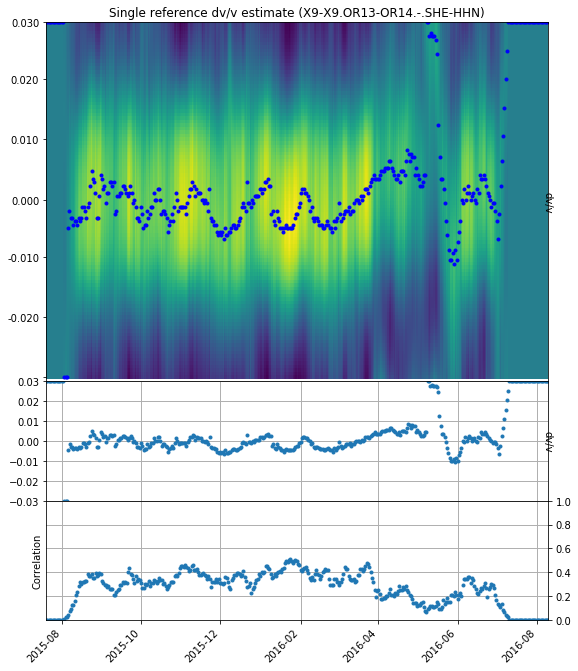

In [11]:
pf.plot_dv(tav)

In [12]:
nums = [1,2,3,4,6,7,10,11,12,13,18]
stats = ['X9.IR%d' % num for num in nums]
stats

['X9.IR1',
 'X9.IR2',
 'X9.IR3',
 'X9.IR4',
 'X9.IR6',
 'X9.IR7',
 'X9.IR10',
 'X9.IR11',
 'X9.IR12',
 'X9.IR13',
 'X9.IR18']